### Bag of Words Meets Bags of Popcorn
#### Use Google's Word2Vec for movie reviews. Predict whether the movie review is positive or negative

In [75]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import string
from bs4 import BeautifulSoup     
import nltk
import nltk.data
from gensim.models import word2vec
import time
from nltk.corpus import stopwords
import nlppreprocess
from nlppreprocess import NLP
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV, train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize,RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
from collections import  Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout, Bidirectional, GRU
from keras.initializers import Constant
from keras.optimizers import Adam, sgd, rmsprop
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler


In [2]:
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [3]:
train_extra = pd.read_csv("unlabeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [4]:
test = pd.read_csv("testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [78]:
submission = pd.read_csv("sampleSubmission.csv")

In [5]:
train.shape

(25000, 3)

In [6]:
train_extra.shape

(50000, 2)

In [7]:
test.shape

(25000, 2)

In [8]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [9]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [12]:
train.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

In [13]:
test.isnull().sum()

id        0
review    0
dtype: int64

In [14]:
train.dtypes

id           object
sentiment     int64
review       object
dtype: object

In [15]:
test.dtypes

id        object
review    object
dtype: object

In [16]:
train.review[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [17]:
test.review[0]

'"Naturally in a film who\'s main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there is a craftsmanship and completeness to the film which anyone can enjoy. The pace is steady and constant, the characters full and engaging, the relationships and interactions natural showing that you do not need floods of tears to show emotion, screams to show fear, shouting to show dispute or violence to show anger. Naturally Joyce\'s short story lends the film a ready made structure as perfect as a polished diamond, but the small changes Huston makes such as the inclusion of the poem fit in neatly. It is truly a masterpiece of tact, subtlety and overwhelming beauty."'

In [18]:
len(train)

25000

In [19]:
len(test)

25000

In [20]:
s = (train.dtypes == 'object')
object_cols = list(s[s].index)
print("categorical attributes")
print(object_cols)

categorical attributes
['id', 'review']


### Percentage of missing values in training data

In [21]:
train_missing_percent = train.isnull().mean()*100
a = pd.DataFrame({"Training data missing percentage": train_missing_percent.sort_values(ascending = False)})
a

,Training data missing percentage
review,0.0
sentiment,0.0
id,0.0


In [22]:
test_missing_percent = test.isnull().mean()*100
b = pd.DataFrame({"Test data missing percentage": test_missing_percent.sort_values(ascending = False)})
b

,Test data missing percentage
review,0.0
id,0.0


### lets view some of positive sentiment reviews (sentiment = 1)

In [23]:
pos_sentiment_reviews = train[train['sentiment']==1]['review']
pos_sentiment_reviews.head(10)

0     "With all this stuff going down at the moment ...
1     "\"The Classic War of the Worlds\" by Timothy ...
4     "Superbly trashy and wondrously unpretentious ...
5     "I dont know why people think this is such a b...
9     "<br /><br />This movie is full of references....
11    "Although I generally do not like remakes beli...
12    "\"Mr. Harvey Lights a Candle\" is anchored by...
18    "This movie is one among the very few Indian m...
19    "Most people, especially young people, may not...
20    "\"Soylent Green\" is one of the best and most...
Name: review, dtype: object

### lets view some of negative sentiment reviews (sentiment = 0)

In [24]:
neg_sentiment_reviews = train[train['sentiment']==0]['review']
neg_sentiment_reviews.head(10)

2     "The film starts with a manager (Nicholas Bell...
3     "It must be assumed that those who praised thi...
6     "This movie could have been very good, but com...
7     "I watched this video at a friend's house. I'm...
8     "A friend of mine bought this film for £1, and...
10    "What happens when an army of wetbacks, towelh...
13    "I had a feeling that after \"Submerged\", thi...
14    "note to George Litman, and others: the Myster...
15    "Stephen King adaptation (scripted by King him...
16    "`The Matrix' was an exciting summer blockbust...
Name: review, dtype: object

In [25]:
train.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

### positive sentiment vs negative sentiment

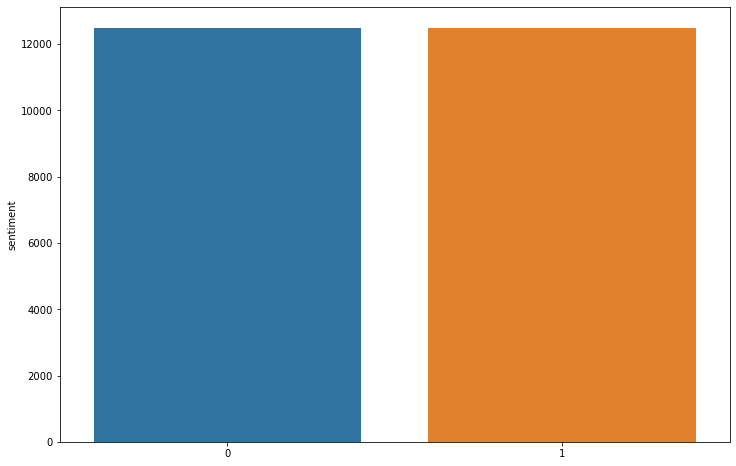

In [26]:
plt.figure(figsize = (12, 8))
sns.barplot(train['sentiment'].value_counts().index, train['sentiment'].value_counts())

### Add a new feature text_length

In [27]:
train['text_length'] = train['review'].apply(lambda x: len(x))
test['text_length'] = test['review'].apply(lambda x: len(x))

In [28]:
train.head()

,id,sentiment,review,text_length
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",2304
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",948
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",2451
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",2247
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",2233


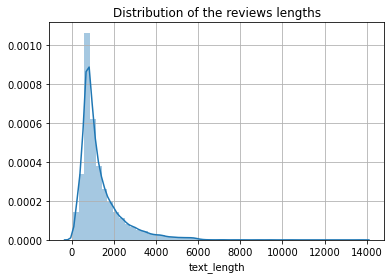

In [29]:
#Create distribution chart to visualize text length distribution
ax=sns.distplot(train['text_length']).set_title('Distribution of the reviews lengths');
plt.grid(True)

### Text preprocessing

In [30]:
def preprocessing(text):
    # 1. Remove html tags
    review_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters and replace with space
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 4. convert stop words to a set for faster searching
    stops = set(stopwords.words("english"))
    
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into a string
    return (" ".join(meaningful_words))
    

In [31]:
train_label = train['sentiment'].copy()

In [32]:
train1 = train.drop('sentiment', axis=1)
train1.head()

,id,review,text_length
0,"""5814_8""","""With all this stuff going down at the moment ...",2304
1,"""2381_9""","""\""The Classic War of the Worlds\"" by Timothy ...",948
2,"""7759_3""","""The film starts with a manager (Nicholas Bell...",2451
3,"""3630_4""","""It must be assumed that those who praised thi...",2247
4,"""9495_8""","""Superbly trashy and wondrously unpretentious ...",2233


In [33]:
# Number of reviews in training set
num_reviews = train1['review'].size

clean_train_reviews = []

print("cleaning and parsing the reviews in training set\n")

for i in range(0, num_reviews):
    if( (i+1)%1000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_reviews ))
    clean_train_reviews.append(preprocessing(train1['review'][i]))



cleaning and parsing the reviews in training set

Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



#### Our preprocessing function successfully eliminated html tags, punctuation, stop words, numbers, every words in lower case

In [34]:
clean_train_reviews[2]

'film starts manager nicholas bell giving welcome investors robert carradine primal park secret project mutating primal animal using fossilized dna like jurassik park scientists resurrect one nature fearsome predators sabretooth tiger smilodon scientific ambition turns deadly however high voltage fence opened creature escape begins savagely stalking prey human visitors tourists scientific meanwhile youngsters enter restricted area security center attacked pack large pre historical animals deadlier bigger addition security agent stacy haiduk mate brian wimmer fight hardly carnivorous smilodons sabretooths course real star stars astounding terrifyingly though convincing giant animals savagely stalking prey group run afoul fight one nature fearsome predators furthermore third sabretooth dangerous slow stalks victims movie delivers goods lots blood gore beheading hair raising chills full scares sabretooths appear mediocre special effects story provides exciting stirring entertainment resul

#### without text processing

In [36]:
train1['review'][2]

'"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature\'s most fearsome predators, the Sabretooth tiger or Smilodon . Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger . In addition , a security agent (Stacy Haiduk) and her mate (Brian Wimmer) fight hardly against the carnivorous Smilodons. The Sabretooths, themselves , of course, are the real star stars and they are astounding terrifyingly though not convincing. The giant animals savagely are stalking its prey and the group run afoul and fight against 

In [37]:
# Number of reviews in test set
num_reviews_test = test['review'].size

clean_test_reviews = []

print("cleaning and parsing the reviews in test set\n")

for i in range(0, num_reviews_test):
    if( (i+1)%1000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_reviews_test ))
    clean_test_reviews.append(preprocessing(test['review'][i]))


cleaning and parsing the reviews in test set

Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



In [38]:
clean_test_reviews[1]

'movie disaster within disaster film full great action scenes meaningful throw away sense reality let see word wise lava burns steam burns stand next lava diverting minor lava flow difficult let alone significant one scares think might actually believe saw movie even worse significant amount talent went making film mean acting actually good effects average hard believe somebody read scripts allowed talent wasted guess suggestion would movie start tv look away like train wreck awful know coming watch look away spend time meaningful content'

In [38]:
test['review'][1]

'"This movie is a disaster within a disaster film. It is full of great action scenes, which are only meaningful if you throw away all sense of reality. Let\'s see, word to the wise, lava burns you; steam burns you. You can\'t stand next to lava. Diverting a minor lava flow is difficult, let alone a significant one. Scares me to think that some might actually believe what they saw in this movie.<br /><br />Even worse is the significant amount of talent that went into making this film. I mean the acting is actually very good. The effects are above average. Hard to believe somebody read the scripts for this and allowed all this talent to be wasted. I guess my suggestion would be that if this movie is about to start on TV ... look away! It is like a train wreck: it is so awful that once you know what is coming, you just have to watch. Look away and spend your time on more meaningful content."'

### Bag of Words - CountVectorizer

In [56]:
vectorizer = CountVectorizer(analyzer = 'word', max_features = 20000)

train_vectors = vectorizer.fit_transform(clean_train_reviews)
test_vectors = vectorizer.transform(clean_test_reviews)

train_vectors_array = train_vectors.toarray()
test_vectors_array = test_vectors.toarray()

In [85]:
test_vectors_array.shape

(25000, 20000)

In [57]:
review1 = train1['review'][1]
review1

'"\\"The Classic War of the Worlds\\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells\' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \\"critics\\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \\"critics\\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells\' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \\"critics\\" perceive to be its shortcomings."'

In [58]:
vec = vectorizer.transform([review1])
print(vec)

  (0, 356)	1
  (0, 523)	1
  (0, 798)	1
  (0, 1400)	1
  (0, 1956)	2
  (0, 3134)	3
  (0, 3398)	1
  (0, 4100)	1
  (0, 4103)	3
  (0, 4151)	1
  (0, 4873)	1
  (0, 5548)	1
  (0, 5622)	2
  (0, 5884)	1
  (0, 5918)	1
  (0, 5921)	2
  (0, 6102)	1
  (0, 6106)	1
  (0, 6107)	1
  (0, 6369)	1
  (0, 6399)	1
  (0, 6400)	1
  (0, 6450)	1
  (0, 6663)	2
  (0, 7006)	1
  :	:
  (0, 12157)	1
  (0, 12263)	2
  (0, 12498)	1
  (0, 12576)	1
  (0, 12959)	1
  (0, 12965)	1
  (0, 13570)	1
  (0, 14007)	1
  (0, 14229)	1
  (0, 14382)	1
  (0, 14712)	1
  (0, 16006)	1
  (0, 16325)	1
  (0, 16701)	1
  (0, 16874)	1
  (0, 17275)	1
  (0, 17939)	1
  (0, 18071)	1
  (0, 18137)	1
  (0, 19100)	1
  (0, 19360)	1
  (0, 19416)	1
  (0, 19515)	2
  (0, 19780)	1
  (0, 19890)	1


In [59]:
vec.shape

(1, 20000)

In [60]:
print(vectorizer.get_feature_names()[19890])

year


In [61]:
train_vectors_array.shape

(25000, 20000)

In [62]:
test_vectors_array.shape

(25000, 20000)

In [63]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
vocab

['aag',
 'aames',
 'aardman',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandons',
 'abbas',
 'abbey',
 'abbot',
 'abbott',
 'abby',
 'abc',
 'abducted',
 'abduction',
 'abe',
 'abetted',
 'abhay',
 'abhorrent',
 'abiding',
 'abigail',
 'abilities',
 'ability',
 'abject',
 'able',
 'ably',
 'abnormal',
 'abo',
 'aboard',
 'abominable',
 'abomination',
 'aboriginal',
 'aborigine',
 'aborigines',
 'aborted',
 'abortion',
 'abortions',
 'abound',
 'abounds',
 'abraham',
 'abrasive',
 'abridged',
 'abroad',
 'abrupt',
 'abruptly',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbing',
 'abstract',
 'absurd',
 'absurdist',
 'absurdities',
 'absurdity',
 'absurdly',
 'abu',
 'abundance',
 'abundant',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'abusive',
 'abysmal',
 'abysmally',
 'abyss',
 'academic',
 'academy',
 'accent',
 'accented',
 'accents',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'accep

### print the count of each words in the vocabulary

In [65]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_vectors_array, axis=0)

# For each, print the vocabulary word and the number of times it appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

23 aag
15 aames
12 aardman
48 aaron
17 ab
51 abandon
187 abandoned
19 abandoning
16 abandonment
15 abandons
12 abbas
24 abbey
27 abbot
30 abbott
28 abby
125 abc
30 abducted
14 abduction
24 abe
15 abetted
27 abhay
16 abhorrent
24 abiding
26 abigail
108 abilities
454 ability
10 abject
1259 able
27 ably
11 abnormal
13 abo
37 aboard
31 abominable
42 abomination
28 aboriginal
14 aborigine
20 aborigines
21 aborted
50 abortion
10 abortions
51 abound
10 abounds
85 abraham
13 abrasive
11 abridged
38 abroad
73 abrupt
60 abruptly
116 absence
83 absent
352 absolute
1485 absolutely
20 absorb
70 absorbed
57 absorbing
38 abstract
306 absurd
18 absurdist
10 absurdities
76 absurdity
24 absurdly
40 abu
44 abundance
22 abundant
192 abuse
77 abused
10 abuses
20 abusing
91 abusive
98 abysmal
12 abysmally
19 abyss
35 academic
297 academy
485 accent
16 accented
203 accents
300 accept
130 acceptable
71 acceptance
144 accepted
57 accepting
74 accepts
92 access
60 accessible
318 accident
46 accidental
200 accid

In [66]:
# Vectorize the text using TFIDF
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))

train_tfidf = tfidf.fit_transform(clean_train_reviews)
test_tfidf = tfidf.transform(clean_test_reviews)

In [67]:
tf = tfidf.transform([review1])

(25000, 346046)

### Model1 - RandomForestClassifier

In [68]:
rnd_fst = RandomForestClassifier()

rnd_fst.fit(train_vectors_array, train_label)

pred_rnd_fst = rnd_fst.predict(train_vectors_array)

In [69]:
from sklearn.metrics import roc_auc_score

roc_auc_score(train_label, pred_rnd_fst)

1.0

##### On test set roc_auc_score using random forest classifier is 0.8554

In [90]:
result1 = rnd_fst.predict(test_tfidf)
output1 = pd.DataFrame( data={"id":test["id"], "sentiment":result1} )
output1.to_csv( "Bag_of_Words_model1.csv", index=False, quoting=3 )

### Model2 - LogisticRegression

In [71]:
log_reg = LogisticRegression()
log_reg.fit(train_vectors_array, train_label)
pred_log_reg = log_reg.predict(train_vectors_array)

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [72]:
roc_auc_score(train_label, pred_log_reg)

0.99628

##### On test set roc_auc_score using logistic regression is 0.885

In [89]:
result = log_reg.predict(test_tfidf)
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

In [51]:
def preprocessing_for_wordvec(text, remove_stopwords=False):
    # 1. Remove html tags
    review_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters and replace with space
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 4. convert stop words to a set for faster searching
    if remove_stopwords:
        stops = set(stopwords.words("english"))
    # 5. Remove stop words
        words = [w for w in words if not w in stops]
    
    # 6. Join the words back into a string
    return(words)
    

In [49]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call preprocessing_for_wordvec to get a list of words
            sentences.append(preprocessing_for_wordvec( raw_sentence, remove_stopwords ))
    
    # Return the list of sentences, each sentence is a list of words, so this returns a list of lists
    return sentences

### Now we can apply the above function to prepare our data for input to word2vec

In [57]:
sentences = []  # initialize an empty list of sentences
sentences1 = []  # initialize an empty list of sentences


print('parsing training set sentences')

for review in train['review']:
    sentences1 += review_to_sentences(review, tokenizer)

print('parsing unlabeled training set sentences')

for review in train_extra['review']:
    sentences += review_to_sentences(review, tokenizer)



parsing training set sentences


c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\bs4\__ini

parsing unlabeled training set sentences


c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:333: MarkupResemblesLocatorWarning: "... ..." looks like a filename, not markup. You should probably open this file and pas

In [58]:
len(sentences1)

266551

In [59]:
print(sentences[1])

['maybe', 'they', 'were', 'sitting', 'around', 'one', 'day', 'in', 'film', 'school', 'and', 'said', 'hey', 'let', 's', 'pool', 'our', 'money', 'together', 'and', 'make', 'a', 'really', 'bad', 'movie', 'or', 'something', 'like', 'that']


##### If you are appending a list of lists to another list of lists, "append" will only append the first list. you need to use "+=" in order to join all of the lists at once.

In [131]:
# Import the built-in logging module and configure it so that Word2Vec creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300    # word vector dimension
min_word_count = 50   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # context window size
downsampling = 1e-4   # Downsampling for requent words

print('Training model')
model = word2vec.Word2Vec(sentences, workers = num_workers, size = num_features, min_count = min_word_count, window = context, 
                         sample = downsampling)
model_name = "300features_50minwords_10context"
model.save(model_name)


2020-07-03 17:40:00,762 : INFO : collecting all words and their counts
2020-07-03 17:40:00,763 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-03 17:40:00,807 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2020-07-03 17:40:00,882 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types
2020-07-03 17:40:00,952 : INFO : PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types


Training model


2020-07-03 17:40:01,013 : INFO : PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types
2020-07-03 17:40:01,069 : INFO : PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types
2020-07-03 17:40:01,130 : INFO : PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types
2020-07-03 17:40:01,186 : INFO : PROGRESS: at sentence #70000, processed 1561580 words, keeping 43333 word types
2020-07-03 17:40:01,247 : INFO : PROGRESS: at sentence #80000, processed 1780887 words, keeping 45714 word types
2020-07-03 17:40:01,314 : INFO : PROGRESS: at sentence #90000, processed 2004996 words, keeping 48135 word types
2020-07-03 17:40:01,416 : INFO : PROGRESS: at sentence #100000, processed 2226966 words, keeping 50207 word types
2020-07-03 17:40:01,506 : INFO : PROGRESS: at sentence #110000, processed 2446580 words, keeping 52081 word types
2020-07-03 17:40:01,626 : INFO : PROGRESS: at sentence #120000, processed 2668775 words, keepin

### Explore word2vec model results

In [132]:
model.doesnt_match('father doctor mother homemaker'.split())

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
2020-07-03 17:43:32,382 : INFO : precomputing L2-norms of word weight vectors
2020-07-03 17:43:32,406 : WARNING : vectors for words {'homemaker'} are not present in the model, ignoring these words
c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'doctor'

In [137]:
model.doesnt_match('orange apple banana king queen'.split())

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'king'

In [139]:
model.most_similar('sister')

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('daughter', 0.804233968257904),
 ('niece', 0.7986921668052673),
 ('grandmother', 0.7780932784080505),
 ('mother', 0.7735996246337891),
 ('aunt', 0.7712572813034058),
 ('mum', 0.7569013833999634),
 ('brother', 0.744199812412262),
 ('cousin', 0.7260096073150635),
 ('boyfriend', 0.7254349589347839),
 ('youngest', 0.7046632766723633)]

In [143]:
model.most_similar('man')

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('woman', 0.6099488735198975),
 ('lad', 0.526140034198761),
 ('lady', 0.5200974345207214),
 ('businessman', 0.5142967104911804),
 ('monk', 0.5127208828926086),
 ('boy', 0.5094033479690552),
 ('soldier', 0.4983328580856323),
 ('men', 0.4935067892074585),
 ('millionaire', 0.4826766550540924),
 ('farmer', 0.48100122809410095)]

In [144]:
model.most_similar('farmer')

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ranch', 0.824034571647644),
 ('unknowingly', 0.8102607727050781),
 ('flees', 0.8010543584823608),
 ('mechanic', 0.8007156848907471),
 ('salesman', 0.7931227684020996),
 ('banker', 0.7922376394271851),
 ('caretaker', 0.7786587476730347),
 ('bartender', 0.7770927548408508),
 ('meanwhile', 0.7762100696563721),
 ('frankie', 0.7722129821777344)]

#### Word2Vec model trained consists of a feature vector for each word in the vocabulary, stored in a numpy array called "syn0"

In [147]:
from gensim.models import Word2Vec
model = Word2Vec.load('300features_50minwords_10context')

2020-07-03 17:54:14,453 : INFO : loading Word2Vec object from 300features_50minwords_10context
2020-07-03 17:54:14,940 : INFO : loading wv recursively from 300features_50minwords_10context.wv.* with mmap=None
2020-07-03 17:54:14,940 : INFO : setting ignored attribute vectors_norm to None
2020-07-03 17:54:14,940 : INFO : loading vocabulary recursively from 300features_50minwords_10context.vocabulary.* with mmap=None
2020-07-03 17:54:14,956 : INFO : loading trainables recursively from 300features_50minwords_10context.trainables.* with mmap=None
2020-07-03 17:54:14,957 : INFO : setting ignored attribute cum_table to None
2020-07-03 17:54:14,958 : INFO : loaded 300features_50minwords_10context


In [151]:
type(model.wv.syn0)

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [152]:
model.wv.syn0.shape

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


(14502, 300)

#### The number of rows in syn0 is the number of words in the model's vocabulary, and the number of columns corresponds to the size of the feature vector. Setting the minimum word count to 50 gave us a total vocabulary of 14502 words with 300 features apiece. Individual word vectors can be accessed in the following way, which returns a 1x300 numpy array.

In [153]:
model['man']

c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 8.68866205e-01, -1.22614098e+00, -1.16312325e-01,  1.30097657e-01,
       -8.79188478e-02,  1.11200845e+00,  8.41632724e-01, -3.54777813e-01,
       -8.26739848e-01, -8.19909871e-01, -3.78672421e-01,  7.79453516e-01,
        2.18353122e-01, -7.25991070e-01,  4.27413434e-01,  1.74416268e+00,
       -7.34156817e-02, -5.26606798e-01, -5.25522590e-01, -4.78297979e-01,
        3.94467413e-01, -1.53990954e-01, -3.09039325e-01,  8.49318564e-01,
        6.47762060e-01, -1.55404404e-01,  2.88480461e-01, -5.02375782e-01,
        6.38104916e-01,  1.49035227e+00,  7.01325595e-01, -8.76380563e-01,
       -3.72727737e-02, -2.97645509e-01,  3.10698867e-01, -1.32010743e-01,
       -4.15808499e-01,  4.19200137e-02, -1.35598648e+00,  2.69939601e-01,
       -1.66361988e-01, -1.39888534e-02,  2.15225220e-01, -3.81301969e-01,
        2.26267293e-01, -3.63695443e-01,  9.29434597e-01, -8.86838138e-01,
       -1.99256033e-01, -4.42430556e-01,  3.99870038e-01,  1.52923122e-01,
        1.12764764e+00,  

### Vector averaging

#### Since each word is a vector in 300-dimensional space, we can use vector operations to combine the words in each review. One method we can use is to simply average the word vectors in a given review.The following code averages the feature vectors

In [158]:
#Function to average all of the word vectors in a given paragraph
def makeFeatureVec(words, model, num_features):
    #initialize 1d array
    featureVec = np.zeros((num_features,), dtype = 'float32')
    nwords = 0
    # Index2word is a list that contains the names of the words in the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)
    # Loop over each word in the review and, if it is in the model's vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec, model[word])
    
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [159]:
# Given a set of reviews (each one a list of words), calculate the average feature vector for each one and return a 
# 2D numpy array 
def avgFeatureVecs(reviews, model, num_features):
    counter = 0
    # Initialize a 2D numpy array
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 1000th review
        if (counter % 1000 == 0):
            print ("Review %d of %d" % (counter, len(reviews)))
        # Call the function that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter = counter + 1
    return reviewFeatureVecs
    

In [160]:
# Calculate average feature vectors for training and testing sets,using the functions we defined above. 
# Notice that we now use stop word removal.

clean_train_reviews1 = []
for review in train1['review']:
    clean_train_reviews1.append(preprocessing_for_wordvec(review, remove_stopwords = True))

train_data_vecs = avgFeatureVecs(clean_train_reviews1, model, num_features)

clean_test_reviews1 = []
for review in test['review']:
    clean_test_reviews1.append(preprocessing_for_wordvec(review, remove_stopwords = True))

test_data_vecs = avgFeatureVecs(clean_test_reviews1, model, num_features)



Review 0 of 25000


c:\users\mahesh kumar m r\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 220

### lets train random forest classifier using this average paragraph vector

In [161]:
rnd = RandomForestClassifier()
rnd.fit(train_data_vecs, train_label)
rnd_predict = rnd.predict(train_data_vecs)
roc_auc_score(train_label, rnd_predict)

0.99996

In [162]:
result3 = rnd.predict(test_data_vecs)
output3 = pd.DataFrame( data={"id":test["id"], "sentiment":result3} )
output3.to_csv( "Word2Vec_AverageVectors.csv", index=False, quoting=3 )

#### I found that average paragraph vector produced roc_auc_score of 0.8383, which is not better than Bag of Words(roc_auc_score = 0.888).

### TensorFlow and Keras model

In [35]:
train1['review'] = train1['review'].apply(lambda x: preprocessing(x))
test['review'] = test['review'].apply(lambda x: preprocessing(x))

In [36]:
train_rev = train1.review.values
train_rev.shape

(25000,)

In [37]:
test_rev = test.review.values
test_rev.shape

(25000,)

In [38]:
train_label.shape

(25000,)

In [60]:
max_features = 10000

word_tokenizer = Tokenizer(num_words = max_features)
word_tokenizer.fit_on_texts(train_rev)
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

74066

In [41]:
def metrics_analyze(pred_target, y_test):
    print("F1-score: ", f1_score(pred_target, y_test))
    print("Precision: ", precision_score(pred_target, y_test))
    print("Recall: ", recall_score(pred_target, y_test))
    print("Acuracy: ", accuracy_score(pred_target, y_test))
    print("ROC_AUC_CURVE: ", roc_auc_score(pred_target, y_test))
    print("-"*50)
    print(classification_report(pred_target, y_test))

In [42]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [43]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' +string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' +string])
    plt.show()

In [44]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Mahesh Kumar M
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
longest_train = max(train_rev, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
train_padded_sentences = pad_sequences(embed(train_rev), length_long_sentence, padding='post')
test_padded_sentences = pad_sequences(embed(test_rev), length_long_sentence, padding='post')

In [46]:
length_long_sentence

1416

### train word2vec model using our training data

In [61]:
from gensim.models import Word2Vec

embedding_vector_size = 200
# now training embeddings for each word using Word2Vec
model_1 = Word2Vec(sentences1, size=embedding_vector_size, min_count=1, window=10, workers=4 )

# to get total number of unique words
words1 = list(model_1.wv.vocab)

print("vocab size:", len(words1))

vocab size: 74218


In [62]:
# Preparing embedding matrix
embedding_matrix = np.zeros((vocab_length, embedding_vector_size))

for  word, index in word_tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [63]:
embedding_matrix.shape

(74066, 200)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(train_padded_sentences, train_label, test_size=0.20)

In [65]:
X_train.shape

(20000, 1416)

In [66]:
X_test.shape

(5000, 1416)

In [67]:
model4 = Sequential()
embedding_layer = Embedding(vocab_length, embedding_vector_size, weights = [embedding_matrix], input_length = length_long_sentence, trainable = False)
model4.add(embedding_layer)
model4.add(Bidirectional(LSTM(64, return_sequences = True)))
model4.add(Bidirectional(LSTM(32)))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(1, activation = 'sigmoid'))

In [68]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1416, 200)         14813200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1416, 128)         135680    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 14,994,321
Trainable params: 181,121
Non-trainable params: 14,813,200
_________________________________________________________________


In [69]:
adam = tf.keras.optimizers.Adam(lr = 0.01)
model4.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [70]:
num_epochs = 10
early_stopping = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

In [71]:
history = model4.fit(X_train, y_train, epochs = num_epochs, validation_data = [X_test, y_test], callbacks = [early_stopping])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2846s 142ms/step - loss: 0.4144 - accuracy: 0.8151 - val_loss: 0.3379 - val_accuracy: 0.8598
Epoch 2/10
20000/20000 [==============================] - 1805s 90ms/step - loss: 0.3167 - accuracy: 0.8683 - val_loss: 0.3428 - val_accuracy: 0.8556
Epoch 3/10
20000/20000 [==============================] - 1915s 96ms/step - loss: 0.3037 - accuracy: 0.8764 - val_loss: 0.3128 - val_accuracy: 0.8692
Epoch 4/10
20000/20000 [==============================] - 1965s 98ms/step - loss: 0.2832 - accuracy: 0.8824 - val_loss: 0.3107 - val_accuracy: 0.8754
Epoch 5/10
20000/20000 [==============================] - 3402s 170ms/step - loss: 0.2729 - accuracy: 0.8889 - val_loss: 0.3028 - val_accuracy: 0.8762
Epoch 6/10
20000/20000 [==============================] - 4580s 229ms/step - loss: 0.2665 - accuracy: 0.8924 - val_loss: 0.2978 - val_accuracy: 0.8742
Epoch 7/10
20000/20000 [========================

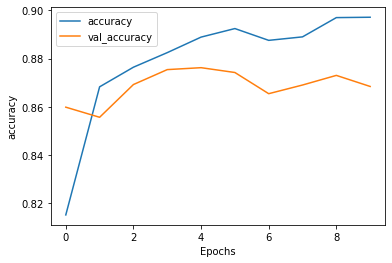

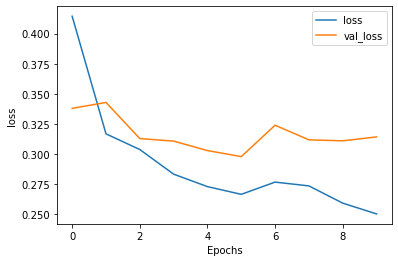

In [72]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [73]:
preds = model4.predict_classes(X_test)

In [76]:
metrics_analyze(preds, y_test)

F1-score:  0.8706761006289309
Precision:  0.8765334388603087
Recall:  0.8648965247950019
Acuracy:  0.8684
ROC_AUC_CURVE:  0.8684876227911048
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2439
           1       0.88      0.86      0.87      2561

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [77]:
confusion_matrix(preds, y_test)

array([[2127,  312],
       [ 346, 2215]], dtype=int64)

In [79]:
submission['sentiment'] = model4.predict_classes(test_padded_sentences)
submission.to_csv("submission1.csv", index=False)

#### On test set roc_auc_score using the above model is 0.877